# Benchmark 1: A LiDAR building Segmentation using a U-Net

This benchmark is based on supervised learning of segmenting building footprints from digital elevation models (DEM) on a TensorFlow platform. The purpose of this benchmark is to test the performance of feeding raster geospatial data (DEM) and labels on the fly to a standard U-Net model using a combination of spatial data generator (SDG) and TensorFlow data API. Processing geospatial data using deep learning models requires a trade-off between processing the geospatial data on CPUs and running training and prediction on GPUs. There are a number of advantages of using SDGs, including: handling the geographic projection and the spatial resolution of your remote sensing data, predefining input dimensions, resampling different resolution datasets, and applying callback functions.



## In order to follow this tutorial, prepare your environment as follows 

1. Create a conda environment with Tensorflow 2 


`conda create -n keras-spatial -c anaconda tensorflow`


2. Add matplotlib and Jupyter Lab to the conda environment 

`conda install -c conda-forge matplotlib jupyterlab`

3. Install the package by executing the following command

`pip install git+https://github.com/a2soliman/keras-spatial#egg=keras-spatial` 

In [1]:
# import os
# os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from keras_spatial import SpatialDataGenerator

from rasterio.plot import show
from rasterio.crs import CRS

In [3]:
#import tensorflow as tf 

# I. Generating Samples 
## Creating a Spatial Data Generator for DEM

The example we are using is a segmention task of buildings from a high-resolution digitial elevation model (DEM). Input images are 1) DEM and 2) label of building footprints extracted from the Microsoft Building footprint open-access dataset.

First, we start by defining a Spatial Data Generator for the DEM image, let us call it dem, 

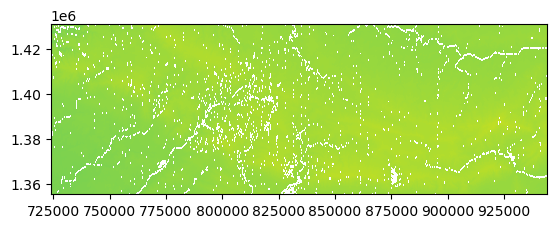

<AxesSubplot:>

In [4]:
dem_path = './data/aoi_dem_deflate.tif'
dem = SpatialDataGenerator(source=dem_path)
show(dem.src)

## Creating a Spatial Data Generator for labels

Then we create a second Spatial Data Generator for the label; let us call it labels.     

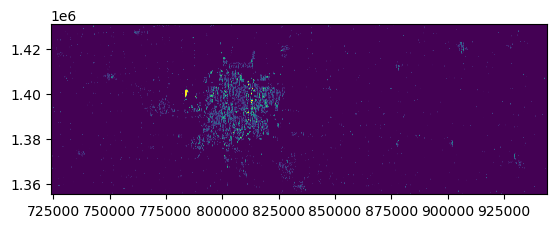

<AxesSubplot:>

In [5]:
label_path = './data/aoi_label_deflate.tif'
labels = SpatialDataGenerator(source=label_path)
show(labels.src)

## Creating a Sample Space   

The second step is to define a sample space. The Sample sapce splits the satellite image/DEM full extent to equally sized geographic areas that are defined in term of the source image native projected units. For example, here we split the dem full extent into equally sized samples with a width and height of 500 feets. Notice that the units are defined in feet because the DEM has a projection of a EPSG:3443 projection with native units in feet. If your satellite image/DEM projective units are defined in meters then your sample space units are in meters. 

Notice that the sample space is defined in a vector form and it is completely independent from the final resolution deined in pixels. In otherwords, the SDG could resample an area of 100x100 feet or an area of 200X200 feet into a 100 x 100 pixels arrays. This could be used to the advantage of training Neural Nets using a multiscale data with the same input size.       

Created 66000 samples


,geometry
0,"POLYGON ((724380.000 1355444.990, 724380.000 1..."
1,"POLYGON ((724880.057 1355444.990, 724880.057 1..."
2,"POLYGON ((725380.114 1355444.990, 725380.114 1..."
3,"POLYGON ((725880.171 1355444.990, 725880.171 1..."
4,"POLYGON ((726380.228 1355444.990, 726380.228 1..."


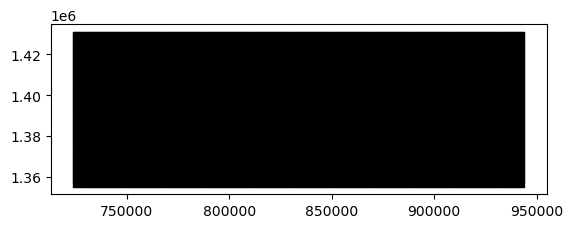

In [6]:
df = dem.regular_grid(500, 500)
print(f'Created {len(df)} samples')

df.plot(color=None, edgecolor='k')
df.head()

By splitting the DEM image into 500 x 500 patches we get 66,000 samples. The samples are saved and maintained in a geo-dataframe to make it easier to select by normal or spatial quieries.

# II. Feeding the Samples to a U-Net using tf.data

In [7]:
# import tensorflow as tf 
# from tensorflow import keras
# from tensorflow.keras import layers

In [8]:
#Step 1: Load libraries for the U-net Model
import numpy as np 
import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

# import skimage.io as io
# import skimage.transform as trans

In [9]:
tf.keras.backend.image_data_format()

'channels_last'

# Define the loss function 

In [10]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = keras.sum(y_true * y_pred, axis=[1,2,3])
    union = keras.sum(y_true, axis=[1,2,3]) + keras.sum(y_pred, axis=[1,2,3])
    return keras.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Define the U-Net model 

In [11]:
#Step 2: Define the U-net model with Depth=4

def unet(pretrained_weights = None,input_size = (128,128,1)):
    
    inputs = tf.keras.Input(shape=input_size)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
   
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5, training=True)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    #model.compile(optimizer = Adam(learning_rate = 0.0001), loss = dice_coef_loss, metrics = dice_coef)
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

# Apply a mirror strategy / Multi Worker Mirrored Strategy

In [12]:
model = unet()
print(model.summary())

2022-12-08 14:27:08.480471: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 14:27:09.420705: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38263 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:85:00.0, compute capability: 8.0
2022-12-08 14:27:09.421956: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38263 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c7:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
#print(model.summary())

In [14]:
# strategy = tf.distribute.MultiWorkerMirroredStrategy()

# with strategy.scope():
#   model = tf.keras.Sequential([
#     tf.keras.layers.Dense(2, input_shape=(5,)),
#   ])
#   optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

# def dataset_fn(ctx):
#   x = np.random.random((2, 5)).astype(np.float32)
#   y = np.random.randint(2, size=(2, 1))
#   dataset = tf.data.Dataset.from_tensor_slices((x, y))
#   return dataset.repeat().batch(1, drop_remainder=True)
# dist_dataset = strategy.distribute_datasets_from_function(dataset_fn)

# model.compile()
# model.fit(dist_dataset)

## Connecting Spatial Data Generators to the U-Net  

We first start by defining the number of samples per batch (32 in this example). Then we estimate the number of steps in a single epoch by estimating the floor division  of (samples per batch)//(total number of samples)

For simplicity, I droped the extra eight samples to obtain a number of samples dividable by number of samples in a single batch (32 samples) without any remaning     

## Remove extra rows from the df 

In [15]:
batch_size = 32
#df = samples 

n_steps = len(df)// batch_size # estimate the number of steps given the batch size 
n_extra = len(df) - (batch_size*n_steps) # estimating the number of extra row 
df.drop(df.tail(n_extra).index,inplace = True) # Dropping extra rows 

In [16]:
len(df)

65984

## Combine the images(x) and labels(Y) sgens  

Here we will take advantage of the Tensorflow tf.data APIs to feed our selected sample to the toy ConvNet model. You should notice that the batch_size variable of the SDG is set to one because the tf.data APIs handles the batch size for us. Most likely the option of defining a batch_size within an SDG will be deprecated in the future to avoid confusion.

We will start by instantiating two Dataset objects usig tf.data API for both the dem and the labels rasters. The source of data is the DEM and labels SDG respectively. Notice that a tf Dataset object is a Python iterable. The batch size is defined using tf.data as 32 samples per batch for both SDGs. Notice that the dataset will be repeated mutliple times to match the number of requested epochs. The cache option is added in order to hold the samples after reading them during first epoch in the cache memory and reuse them for subsequent epochs. 

In [17]:
# width, height, batch_length, epochs  = 128,128,32,20


# x_sgen = dem.flow_from_dataframe(df, width, height, batch_size=1)
# datasetx = tf.data.Dataset.from_generator(lambda: map(tuple, x_sgen), (tf.float32))
# datasetx = datasetx.batch(batch_length)
# #datasetx = datasetx.repeat(count = epochs)
# datasetx = datasetx.cache().repeat(epochs)
# datasetx = datasetx.prefetch(5)

# y_sgen = labels.flow_from_dataframe(df, width, height, batch_size=1)
# datasety = tf.data.Dataset.from_generator(lambda: map(tuple, y_sgen), (tf.float32))
# datasety = datasety.batch(batch_length)
# #datasety = datasety.repeat(count = epochs)
# datasety = datasety.cache().repeat(epochs)
# datasety = datasety.prefetch(5)

In [18]:
# width, height, batch_length, epochs  = 128,128,32,20


# # Disable AutoShard.
# options = tf.data.Options()
# options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

# x_sgen = dem.flow_from_dataframe(df, width, height, batch_size=1)
# datasetx = tf.data.Dataset.from_generator(lambda: map(tuple, x_sgen), (tf.float32))
# datasetx = datasetx.with_options(options)
# datasetx = datasetx.batch(batch_length)
# #datasetx = datasetx.repeat(count = epochs)
# datasetx = datasetx.cache().repeat(epochs)
# datasetx = datasetx.prefetch(5)


# y_sgen = labels.flow_from_dataframe(df, width, height, batch_size=1)
# datasety = tf.data.Dataset.from_generator(lambda: map(tuple, y_sgen), (tf.float32))
# datasety = datasety.with_options(options)
# datasety = datasety.batch(batch_length)
# #datasety = datasety.repeat(count = epochs)
# datasety = datasety.cache().repeat(epochs)
# datasety = datasety.prefetch(5)

In [19]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [27]:
width, height, batch_length, epochs  = 128,128,32,20
GLOBAL_BATCH_SIZE = batch_length * strategy.num_replicas_in_sync

# Disable AutoShard.
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

x_sgen = dem.flow_from_dataframe(df, width, height, batch_size=1)
datasetx = tf.data.Dataset.from_generator(lambda: map(tuple, x_sgen), (tf.float32))
datasetx = datasetx.batch(GLOBAL_BATCH_SIZE)
datasetx = datasetx.with_options(options)
#datasetx = datasetx.repeat(count = epochs)
datasetx = datasetx.cache().repeat(epochs)
datasetx = datasetx.prefetch(5)


y_sgen = labels.flow_from_dataframe(df, width, height, batch_size=1)
datasety = tf.data.Dataset.from_generator(lambda: map(tuple, y_sgen), (tf.float32))
datasety = datasety.batch(GLOBAL_BATCH_SIZE)
datasety = datasety.with_options(options)
#datasety = datasety.repeat(count = epochs)
datasety = datasety.cache().repeat(epochs)
datasety = datasety.prefetch(5)

dataset = tf.data.Dataset.zip((datasetx, datasety))

In [28]:
train_dist_dataset = strategy.experimental_distribute_dataset(dataset)


After defining both dem and labels datasets we will zip them before feeding them directly to the U-Net model.

In [29]:
with strategy.scope():
    model = unet()
    model.compile(optimizer = Adam(learning_rate = 0.0001), loss = dice_coef_loss, metrics = dice_coef)

In [30]:
#dataset = zip(datasetx, datasety)

In [31]:
# #Step 3: Initialize Tensorboard to monitor changes in Model Loss 
# import datetime
# %load_ext tensorboard
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [32]:
# #Visualize on tensorboard (move this above)
# %tensorboard --logdir logs/fit

In [ ]:
#Step 4: Fit the u-net model
#model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_DB1_bin.hdf5', monitor='loss',verbose=0)# save_best_only=True)
model.fit(dataset,steps_per_epoch=int(n_steps),epochs=epochs,verbose=1)#allbacks=[tensorboard_callback,model_checkpoint])

Epoch 1/20
INFO:tensorflow:batch_all_reduce: 66 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 66 all-reduces with algorithm = nccl, num_packs = 1
  12/2062 [..............................] - ETA: 2:26:00 - loss: -0.0026 - dice_coef: 0.0026 